# Step1: Creating Second Quantistion Hamiltonian
Example: $C_2H_4$ Molecule

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pyscf import ao2mo, fci, gto, mcscf, scf, tools
from qiskit.quantum_info import SparsePauliOp


def cholesky(V, eps):
    # see https://arxiv.org/pdf/1711.02242.pdf section B2
    # see https://arxiv.org/abs/1808.02625
    # see https://arxiv.org/abs/2104.08957
    no = V.shape[0]
    chmax, ng = 20 * no, 0
    W = V.reshape(no**2, no**2)
    L = np.zeros((no**2, chmax))
    Dmax = np.diagonal(W).copy()
    nu_max = np.argmax(Dmax)
    vmax = Dmax[nu_max]
    while vmax > eps:
        L[:, ng] = W[:, nu_max]
        if ng > 0:
            L[:, ng] -= np.dot(L[:, 0:ng], (L.T)[0:ng, nu_max])
        L[:, ng] /= np.sqrt(vmax)
        Dmax[: no**2] -= L[: no**2, ng] ** 2
        ng += 1
        nu_max = np.argmax(Dmax)
        vmax = Dmax[nu_max]
    L = L[:, :ng].reshape((no, no, ng))
    print(
        "accuracy of Cholesky decomposition ",
        np.abs(np.einsum("prg,qsg->prqs", L, L) - V).max(),
    )
    return L, ng


def identity(n):
    return SparsePauliOp.from_list([("I" * n, 1)])


def creators_destructors(n, mapping="jordan_wigner"):
    c_list = []
    if mapping == "jordan_wigner":
        for p in range(n):
            if p == 0:
                l, r = "I" * (n - 1), ""
            elif p == n - 1:
                l, r = "", "Z" * (n - 1)
            else:
                l, r = "I" * (n - p - 1), "Z" * p
            cp = SparsePauliOp.from_list([(l + "X" + r, 0.5), (l + "Y" + r, -0.5j)])
            c_list.append(cp)
    else:
        raise ValueError("Unsupported mapping.")
    d_list = [cp.adjoint() for cp in c_list]
    return c_list, d_list


def build_hamiltonian(ecore: float, h1e: np.ndarray, h2e: np.ndarray) -> SparsePauliOp:
    ncas, _ = h1e.shape

    C, D = creators_destructors(2 * ncas, mapping="jordan_wigner")
    Exc = []
    for p in range(ncas):
        Excp = [C[p] @ D[p] + C[ncas + p] @ D[ncas + p]]
        for r in range(p + 1, ncas):
            Excp.append(
                C[p] @ D[r]
                + C[ncas + p] @ D[ncas + r]
                + C[r] @ D[p]
                + C[ncas + r] @ D[ncas + p]
            )
        Exc.append(Excp)

    # low-rank decomposition of the Hamiltonian
    Lop, ng = cholesky(h2e, 1e-6)
    t1e = h1e - 0.5 * np.einsum("pxxr->pr", h2e)

    H = ecore * identity(2 * ncas)
    # one-body term
    for p in range(ncas):
        for r in range(p, ncas):
            H += t1e[p, r] * Exc[p][r - p]
    # two-body term
    for g in range(ng):
        Lg = 0 * identity(2 * ncas)
        for p in range(ncas):
            for r in range(p, ncas):
                Lg += Lop[p, r, g] * Exc[p][r - p]
        H += 0.5 * Lg @ Lg

    return H.chop().simplify()

In [2]:
distance = 0.74 # in Angstrom
mol = gto.Mole() # gto = gaussian type orbital
mol.build(
    atom='c2h4.xyz',
    basis="sto-3g",
    spin=0,
    charge=0,
    symmetry=True,
)
print(mol.groupname)
print(mol.irrep_name)


D2h
['Ag', 'B1g', 'B3g', 'B1u', 'B2u', 'B3u']


RHF is a method that finds an approximate ground state energy by assuming electrons are independent and move in an average field (a single Slater determinant).

In [3]:
mf = scf.RHF(mol) # Setting up Restricted Hartree-Fock Calculation
E1 = mf.kernel() # Runs RHF calculation
print(f"Grounf state energy by RHF = {E1} Hartree = {E1*27.2114} eV")
mf.analyze()


converged SCF energy = -77.0720894366185
Grounf state energy by RHF = -77.07208943661851 Hartree = -2097.239454495601 eV
Wave-function symmetry = Ag
occupancy for each irrep:     Ag  B1g  B3g  B1u  B2u  B3u
                               3    1    0    1    2    1
**** MO energy ****
MO #1 (Ag #1), energy= -11.0196614275985 occ= 2
MO #2 (B2u #1), energy= -11.0188896711418 occ= 2
MO #3 (Ag #2), energy= -0.976037099380333 occ= 2
MO #4 (B2u #2), energy= -0.74360298995023 occ= 2
MO #5 (B3u #1), energy= -0.601723886605759 occ= 2
MO #6 (Ag #3), energy= -0.528045032291892 occ= 2
MO #7 (B1g #1), energy= -0.462687390804597 occ= 2
MO #8 (B1u #1), energy= -0.323081777415928 occ= 2
MO #9 (B3g #1), energy= 0.317430713436985 occ= 0
MO #10 (B3u #2), energy= 0.630961212391424 occ= 0
MO #11 (Ag #4), energy= 0.686729607715219 occ= 0
MO #12 (B2u #3), energy= 0.691159122278346 occ= 0
MO #13 (B1g #2), energy= 0.939574765153047 occ= 0
MO #14 (B2u #4), energy= 0.97814772676242 occ= 0
 ** Mulliken atomic char

((array([1.99982852, 1.03311005, 1.02444972, 1.01705199, 1.        ,
         1.99982852, 1.03311005, 1.02444972, 1.01705199, 1.        ,
         0.96277986, 0.96277986, 0.96277986, 0.96277986]),
  array([-0.07444028, -0.07444028,  0.03722014,  0.03722014,  0.03722014,
          0.03722014])),
 array([-2.25752431e-15, -7.89251665e-16,  0.00000000e+00]))

## nelecas (Number of active electrons)
 nelecas = number of active electrons = usually total number of valence electrons

 format = (num_spin_up, num_spin_down)
 For a standard calculation (singlet, spin=0), these are just (TotalActive / 2, TotalActive / 2).

for $H_2$ (1,1)

## ncas (Number of Active Orbitals)
 ncas must be large enough to hold all the active electrons

 ### Strategy 1: Full Valence Active Space (FVAS)
 This is the most common and robust starting point.
 
 Rule: Include all molecular orbitals (MOs) that are formed from the valence atomic orbitals (AOs).

 ### Strategy 2: Minimal "Interesting" Space
 For quantum computing (VQE), FVAS is often too large. You want the smallest possible space that captures the physics.
 
 Rule: Pick only the orbitals directly involved in a process.

 LiH example used ncas=5! This means the person who wrote it chose a larger space, likely the $\sigma$, $\sigma^*$, and the 3 p-orbitals from the Li atom, to get a more accurate result. This was a chemical choice.

## cas_space_symmetry (The Practical Tool)
This argument is just a tool to select the ncas orbitals you chose in the previous step. It's more reliable than just picking by energy because orbital energies can be in the "wrong" order.
run mf.analyze() to get the orbitals for cas_space_symmetry


In [4]:
nelecas = (2,2)
ncas = 4
cas_space_symmetry = {
    'B3u': 1,   # π
    'B3g': 1,   # π*
    'B1g': 1,   # σ
    'Ag':  1    # σ*
}

mx = mcscf.CASCI(mf, ncas = ncas, nelecas=nelecas)
mo = mcscf.sort_mo_by_irrep(mx, mf.mo_coeff, cas_space_symmetry)

E2 = mx.kernel(mo)[:2] # second value is active_space_energy
h1e, ecore = mx.get_h1eff()
h2e = ao2mo.restore(1, mx.get_h2eff(), mx.ncas)
print(f"Ground state energy by RHF = {E1} Hartree = {E1*27.2114} eV")
print(f"Ground State Energy level CASCI = {E2[0]} Hartree = {E2[0]*27.2114} eV")

CASCI E = -76.4553974004252  E(CI) = -3.33930680115536  S^2 = 0.0000000
Ground state energy by RHF = -77.07208943661851 Hartree = -2097.239454495601 eV
Ground State Energy level CASCI = -76.45539740042523 Hartree = -2080.4584008219313 eV


In [5]:
H = build_hamiltonian(ecore, h1e, h2e)

accuracy of Cholesky decomposition  2.220446049250313e-16


# VQE for Ground State Energy

In [6]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp

print(H.num_qubits)

8


15


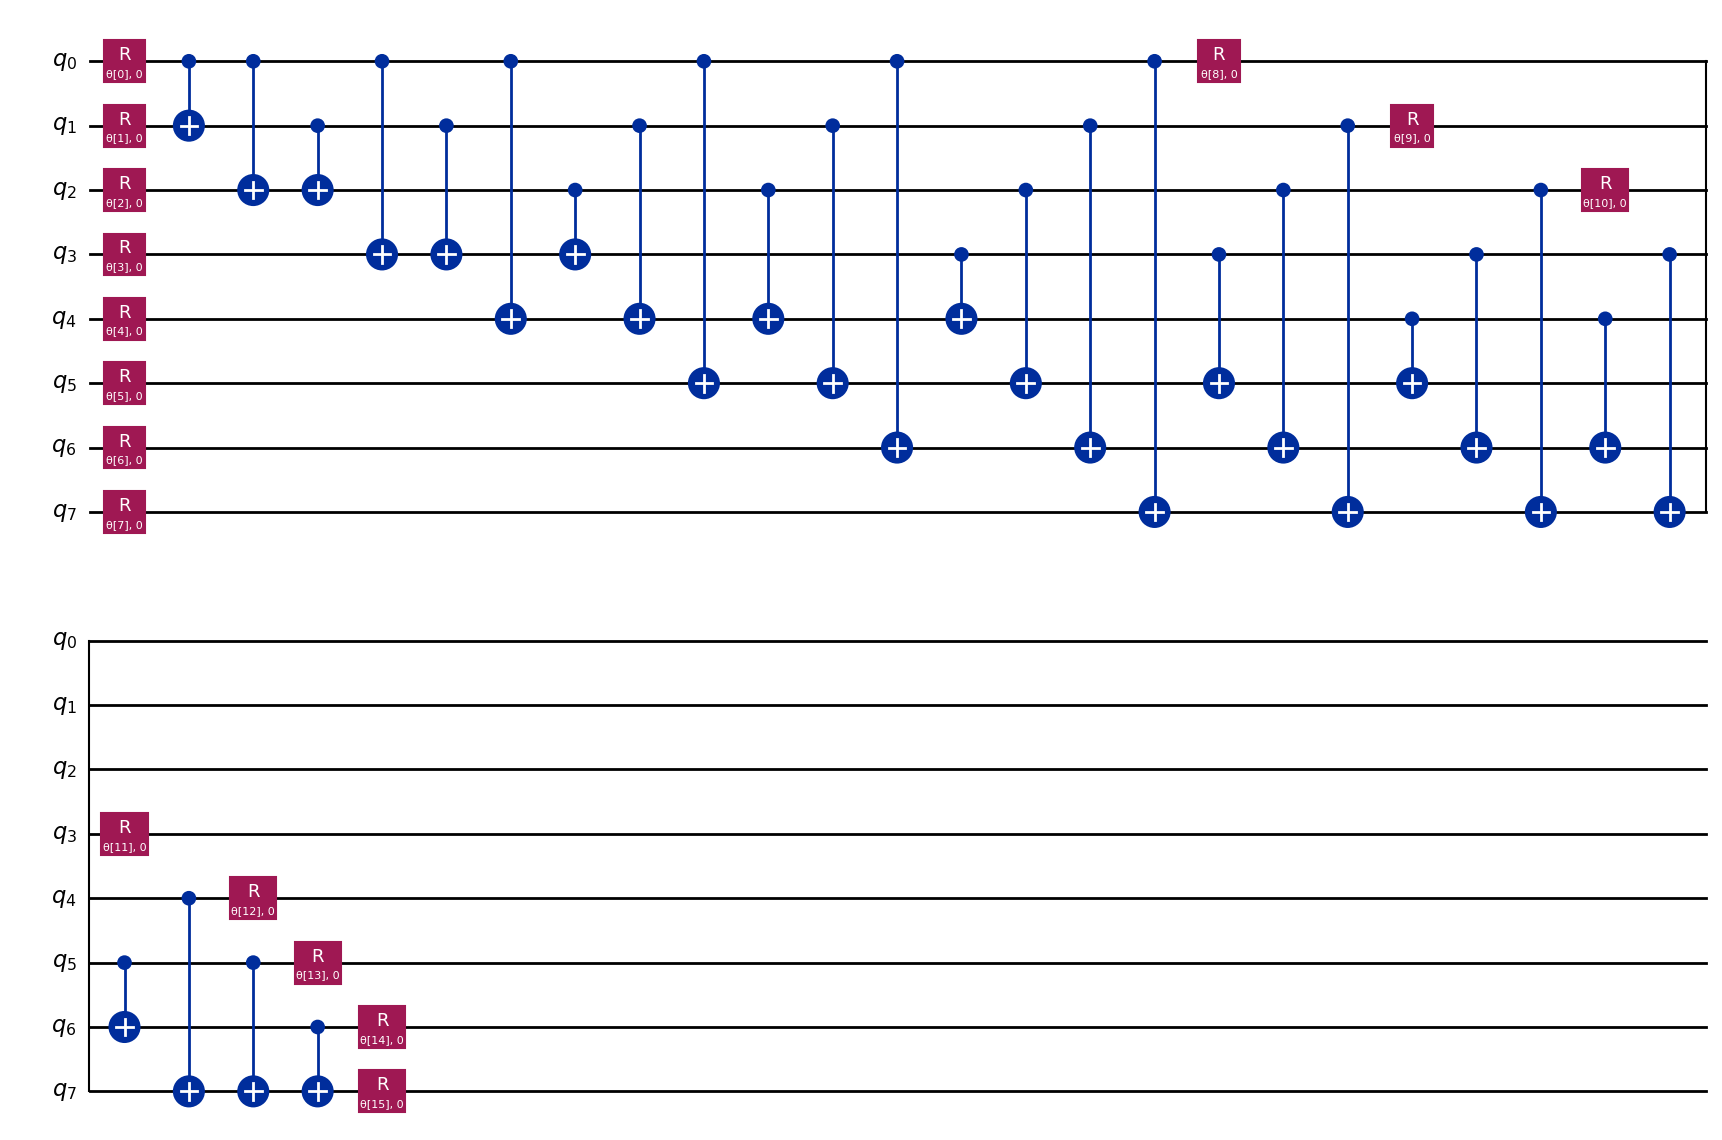

In [7]:
# Pre-defined ansatz circuit
from qiskit.circuit.library import efficient_su2
from scipy.optimize import minimize
# Random initial state and efficient_su2 ansatz
ansatz = efficient_su2(H.num_qubits, su2_gates=["rx"], entanglement="full", reps=1)
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
print(ansatz.decompose().depth())
ansatz.decompose().draw("mpl")

In [8]:
energy_history = []
param_history = []

def cost_func(params, ansatz, H, estimator):
    pub = (ansatz, [H], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    energy_history.append(energy)
    param_history.append(params)
    return energy

In [9]:
# We will start by using a local simulator
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendEstimatorV2

backend = AerSimulator()
estimator = BackendEstimatorV2(backend = backend)

In [10]:
res = minimize(
    cost_func,
    x0,
    args=(ansatz, H, estimator),
    method="cobyla",
    options={"maxiter": 100, "disp": True},
)



   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =  100   F =-7.610367E+01    MAXCV = 0.000000E+00
   X = 3.350516E+00   3.177262E+00   2.446471E+00   3.033547E+00   3.126752E+00
       6.459116E+00   6.159544E+00   4.708781E+00   3.205556E-02   6.744422E+00
       3.764249E+00   6.371069E+00   3.012792E+00   1.607534E+00   1.536647E-01
       1.666700E+00


In [11]:
print(getattr(res, "fun"), "Hartree")
print(res)
E3 = getattr(res, "fun")
print(f"Ground State Energy by VQE = {E3} Hartree = {E3*27.114} eV")
print(f"Ground state energy by RHF = {E1} Hartree = {E1*27.2114} eV")
print(f"Ground State Energy level CASCI = {E2[0]} Hartree = {E2[0]*27.2114} eV")

-76.10366636192666 Hartree
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -76.10366636192666
       x: [ 3.351e+00  3.177e+00 ...  1.537e-01  1.667e+00]
    nfev: 100
   maxcv: 0.0
Ground State Energy by VQE = -76.10366636192666 Hartree = -2063.4748097372794 eV
Ground state energy by RHF = -77.07208943661851 Hartree = -2097.239454495601 eV
Ground State Energy level CASCI = -76.45539740042523 Hartree = -2080.4584008219313 eV


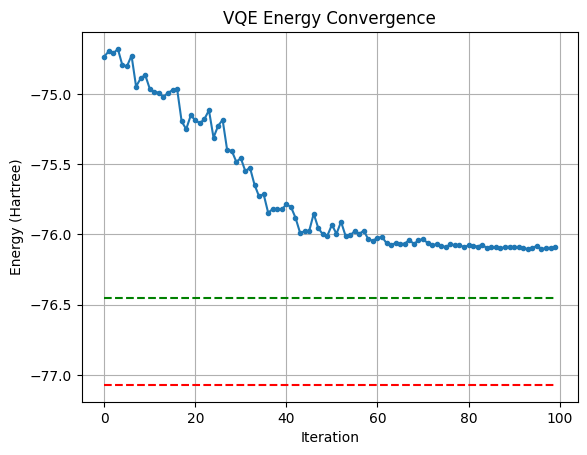

In [12]:
import matplotlib.pyplot as plt
import numpy as np

iters = np.arange(len(energy_history))

plt.figure()
plt.plot(iters, energy_history, '.-')
plt.plot(iters, E1*np.ones(len(iters)),'r--')
plt.plot(iters, E2[0]*np.ones(len(iters)),'g--')
plt.xlabel("Iteration")
plt.ylabel("Energy (Hartree)")
plt.title("VQE Energy Convergence")
plt.grid(True)
plt.show()


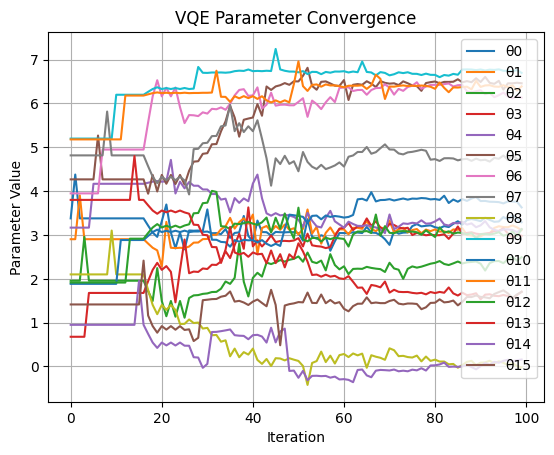

In [13]:
param_history = np.array(param_history)

plt.figure()
for i in range(param_history.shape[1]):
    plt.plot(param_history[:, i], label=f"θ{i}")

plt.xlabel("Iteration")
plt.ylabel("Parameter Value")
plt.title("VQE Parameter Convergence")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
def make_cost_func(ansatz, H, estimator, energy_history):
    def cost_func(params):
        pub = (ansatz, [H], [params])
        result = estimator.run(pubs=[pub]).result()
        energy = result[0].data.evs[0]

        energy_history.append(float(energy))
        return float(energy)

    return cost_func


In [15]:
energy_histories = []   # list of lists
n_runs = 100
maxiter = 100
for i in range(n_runs):
    print(f"Starting run {i+1}/{n_runs}")

    # fresh initial point (randomized)
    x0_run = x0 + 0.1 * np.random.randn(len(x0))

    energy_history = []
    cost_func = make_cost_func(ansatz, H, estimator, energy_history)

    res = minimize(
        cost_func,
        x0_run,
        method="cobyla",
        options={"maxiter": maxiter, "disp": False},
    )

    energy_histories.append(energy_history)
    print(f"Run {i+1} finished: final energy = {res.fun:.6f}")


Starting run 1/100
Run 1 finished: final energy = -76.405441
Starting run 2/100
Run 2 finished: final energy = -76.423015
Starting run 3/100
Run 3 finished: final energy = -76.414020
Starting run 4/100
Run 4 finished: final energy = -76.430104
Starting run 5/100
Run 5 finished: final energy = -76.372392
Starting run 6/100
Run 6 finished: final energy = -76.404281
Starting run 7/100
Run 7 finished: final energy = -76.230342
Starting run 8/100
Run 8 finished: final energy = -76.393896
Starting run 9/100
Run 9 finished: final energy = -76.411385
Starting run 10/100
Run 10 finished: final energy = -76.411347
Starting run 11/100
Run 11 finished: final energy = -76.411002
Starting run 12/100
Run 12 finished: final energy = -75.957812
Starting run 13/100
Run 13 finished: final energy = -76.405620
Starting run 14/100
Run 14 finished: final energy = -76.101748
Starting run 15/100
Run 15 finished: final energy = -76.378721
Starting run 16/100
Run 16 finished: final energy = -76.433992
Starting r

In [16]:
final_energies = [hist[-1] for hist in energy_histories]


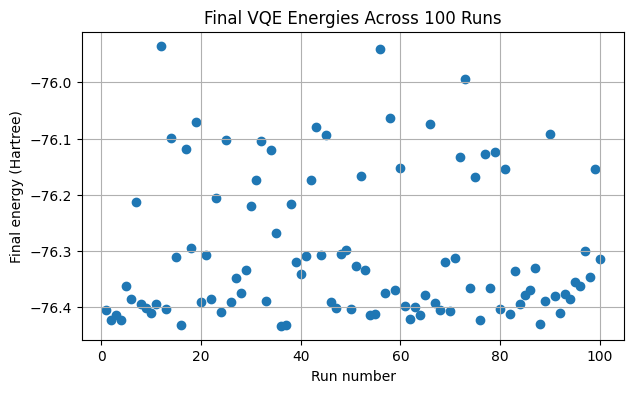

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.scatter(range(1, len(final_energies) + 1), final_energies)
plt.xlabel("Run number")
plt.ylabel("Final energy (Hartree)")
plt.title("Final VQE Energies Across 100 Runs")
plt.grid(True)
plt.show()


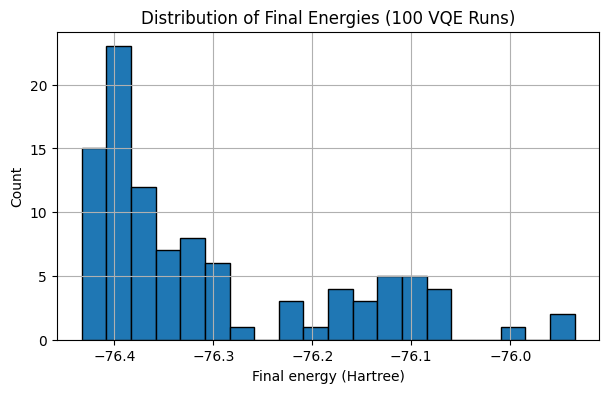

In [26]:
plt.figure(figsize=(7,4))
plt.hist(final_energies, bins=20, edgecolor='black')
plt.xlabel("Final energy (Hartree)")
plt.ylabel("Count")
plt.title("Distribution of Final Energies (100 VQE Runs)")
plt.grid(True)
plt.show()


In [29]:
import json

# -------------------------------
# Convert complex objects safely
# -------------------------------

# 1. Energy histories (ragged list → object array)
energy_hist_obj = np.array(energy_histories, dtype=object)
final_energies_obj = np.array(final_energies, dtype=object)

# 2. Hamiltonian (Qiskit SparsePauliOp → storable list)
H_list = H.to_list()   # list of (pauli_string, coeff)

# 3. cas_space_symmetry (dict → JSON string)
cas_symm_str = json.dumps(cas_space_symmetry)

# -------------------------------
# SAVE EVERYTHING
# -------------------------------

np.savez_compressed(
    "C2H4_100runs_full_Cobyla.npz",

    # --- VQE Data ---
    Energy_History = energy_hist_obj,
    Final_Energies = final_energies_obj,
    Optimizer = "cobyla",
    n_runs = 100,
    iters = 100,

    # --- Energies ---
    RHF_Gs = E1,         # RHF energy
    CASCI_E1 = E2[0],    # Active-space CASCI energy
    CASCI_E2 = E2[1],

    # --- Active Space Info ---
    ncas = ncas,
    nelecas = np.array(nelecas, dtype=int),
    cas_space_symmetry = cas_symm_str,

    # --- Hamiltonian (Pauli form) ---
    Hamiltonian_Pauli_List = np.array(H_list, dtype=object),
)

